Nishan Karki
BINF 3360
Date: 02/03/2022
Assignment1

# A1: Pandas and Matplotlib

# Assignment1: Part 1 

In [194]:
# Importing all required libraries
import re
import pandas as pd
import os
import glob
import datetime
import matplotlib.pyplot as plt
import matplotlib.patches
from pandas import to_datetime
import numpy as np
import seaborn as sns
from matplotlib.patches import Patch

In [195]:
# This function imports data from the .csv files, filters rows by dates and caluculate the seals foraging trips.
def data_import():
    # Assigning current working directory as path location
    path = os.getcwd()
    
    # Attach location to the seal metadata file 
    sealMetadataPath = path + "/data/leopard_seals/LepSealMetadata_1-11-2022.xlsx"

    # Importing seal meatadata file as pandas dataframe
    sealMetadata = pd.read_excel(sealMetadataPath)
    sealMetadata.columns = sealMetadata.columns.str.replace(' ', '')

    # Iterating through all the seals .cvs file names
    path = path + "/data/leopard_seals"
    csvFiles = glob.glob(os.path.join(path, "*.csv"))

    # Iterating through all files and importing all seals data into pandas dataframes
    sealDictionary = dict()
    for i in csvFiles:
        split1 = re.split("_seals/", i)[1]
        sealId = "status_" + re.split("_", split1)[0]
        sealDictionary[sealId] = pd.read_csv(i)
    sealDictionary = dict(sorted(sealDictionary.items()))
    
    # Joining seals dataframe with seals metadata dataframe
    for i in sealDictionary:
        sealDictionary[i] = pd.merge(sealDictionary[i], sealMetadata, on='DeployID',
                                     how='left')
        
        # Filtering seals data received before the deploy date
        filter1 = sealDictionary[i]['Received'] > sealDictionary[i]['DeployDate']
        sealDictionary[i] = sealDictionary[i].where(filter1)
        sealDictionary[i] = sealDictionary[i].dropna(how='all')
        sealDictionary[i] = sealDictionary[i].reset_index(drop=True)

        # Filtering to get data for foraging trips
        forage_Trips = sealDictionary[i].filter(['DeployID', 'HauledOut'])
        
        # Foraging trips counter started with the seal hauled out at 0
        trips_taken = 0
        if forage_Trips.at[0, 'HauledOut'] == 0:
            trips_taken = 1
        else:
            trips_taken = 0
            
        # Assigning trips value to a new column
        forage_Trips.at[0, 'ForagingTrips'] = trips_taken

        # Assigning seals foraging trips values
        for k in forage_Trips.index:
            if k == forage_Trips.index.stop - 1:
                forage_Trips.at[k, 'ForagingTrips'] = trips_taken
            elif (forage_Trips.at[k, 'HauledOut'] == 1) and (forage_Trips.at[k + 1, 'HauledOut'] == 0):
                trips_taken += 1
                forage_Trips.at[k, 'ForagingTrips'] = trips_taken
            else:
                forage_Trips.at[k, 'ForagingTrips'] = trips_taken
        
        # Adding seal foraging trips to filtered seal data
        sealDictionary[i] = pd.concat([sealDictionary[i], forage_Trips.filter(['ForagingTrips'])], axis=1)
        
    return sealDictionary

In [196]:
# This function calculates the seals time spent on water and land
def time_spent(seal_dataframes):
    for i in seal_dataframes:
        haul_data = seal_dataframes[i].filter(['DeployID', 'Received', 'HauledOut', 'ForagingTrips'])
        for k in haul_data.index:
            if k == haul_data.index.stop - 1:
                break
            elif (haul_data.at[k, 'HauledOut'] == 1) and (haul_data.at[k + 1, 'HauledOut'] == 0):
                time_land = pd.Timedelta(
                    to_datetime(haul_data.at[k + 1, 'Received']) - to_datetime(haul_data.at[k, 'Received']))
                haul_data.at[k, 'LandTime'] = datetime.timedelta.total_seconds(time_land)
            elif (haul_data.at[k, 'HauledOut'] == 1) and (haul_data.at[k + 1, 'HauledOut'] == 1):
                time_land = pd.Timedelta(
                    to_datetime(haul_data.at[k + 1, 'Received']) - to_datetime(haul_data.at[k, 'Received']))
                haul_data.at[k, 'LandTime'] = datetime.timedelta.total_seconds(time_land)
            elif (haul_data.at[k, 'HauledOut'] == 0) and (haul_data.at[k + 1, 'HauledOut'] == 1):
                time_water = pd.Timedelta(
                    to_datetime(haul_data.at[k + 1, 'Received']) - to_datetime(haul_data.at[k, 'Received']))
                haul_data.at[k, 'WaterTime'] = datetime.timedelta.total_seconds(time_water)
            elif (haul_data.at[k, 'HauledOut'] == 0) and (haul_data.at[k + 1, 'HauledOut'] == 0):
                time_water = pd.Timedelta(
                    to_datetime(haul_data.at[k + 1, 'Received']) - to_datetime(haul_data.at[k, 'Received']))
                haul_data.at[k, 'WaterTime'] = datetime.timedelta.total_seconds(time_water)
            else:
                print("Break")

        time_spent_ = (haul_data.filter(['DeployID', 'HauledOut', 'Received', 'ForagingTrips', 'LandTime', 'WaterTime']))

        # Calculating land and water percentage
        time_spent_['LandPercent'] = ((time_spent_['LandTime'].sum()) / (
                time_spent_['LandTime'].sum() + time_spent_['WaterTime'].sum())) * 100
        time_spent_['WaterPercent'] = ((time_spent_['WaterTime'].sum()) / (
                time_spent_['LandTime'].sum() + time_spent_['WaterTime'].sum())) * 100

        seal_dataframes[i] = pd.concat(
            [seal_dataframes[i], time_spent_.filter(['LandTime', 'WaterTime', 'LandPercent', 'WaterPercent'])], axis=1)
    return seal_dataframes

In [221]:
# This function calculates the percentage of time spent by indvidual seals in water and plots the data
def water_time_plot(seal_haul_percentage_df):
    individual_haul_data = pd.DataFrame(columns=['DeployID', 'Sex', 'LandPercent', 'WaterPercent', 'ForagingTrips'])
    for i in seal_haul_percentage_df:
        haul_data = seal_haul_percentage_df[i].filter(
            ['DeployID', 'Sex', 'LandPercent', 'WaterPercent', 'ForagingTrips'])
        individual_haul_data = individual_haul_data.append(haul_data.iloc[-1], ignore_index=True)

    individual_haul_data = individual_haul_data.sort_values(by=['Sex', 'DeployID'])
    individual_haul_data = individual_haul_data.reset_index(drop=True)
    
    # Plotting the data
    sns.displot(individual_haul_data, x="Sex", y="WaterPercent", hue='Sex')
    plt.title('Fig 1. A. Percentange of time spent by seals in water')
    plt.show()
    
    individual_haul_data.plot(x="Sex", y=["WaterPercent"], kind='bar', figsize=(10, 10))
    plt.xlabel('Sex')
    plt.ylabel('WaterPercent')
    plt.title('Fig 1. B. Percentange of time spent by seals in water')
    plt.show()
    
    return individual_haul_data

/Users/nises/Desktop/Comp Biology/Assign1


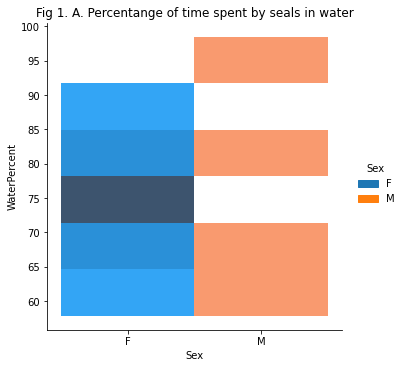

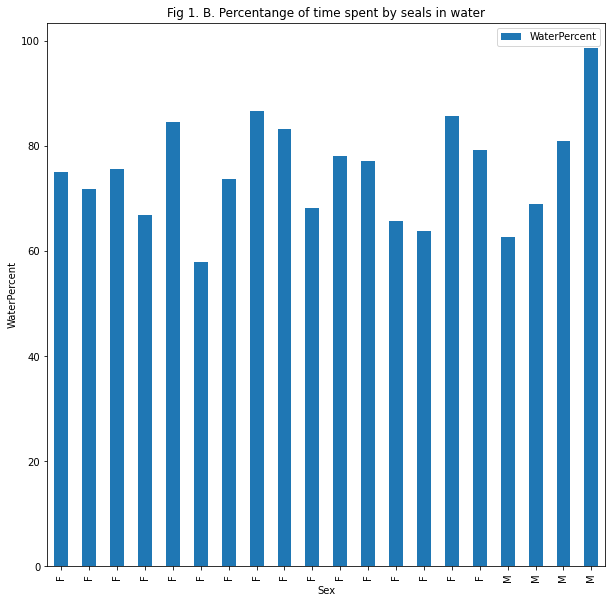

    DeployID Sex  LandPercent  WaterPercent  ForagingTrips
0   173711.0   F    25.058290     74.941710           34.0
1   173712.0   F    28.157310     71.842690           63.0
2   173713.0   F    24.500223     75.499777           32.0
3   173714.0   F    33.185757     66.814243           36.0
4   173717.0   F    15.556801     84.443199           14.0
5   173718.0   F    42.166863     57.833137           25.0
6   173719.0   F    26.293489     73.706511           17.0
7   173721.0   F    13.357236     86.642764           14.0
8   180842.0   F    16.801867     83.198133            2.0
9   180843.0   F    31.757408     68.242592           78.0
10  180851.0   F    21.952377     78.047623           13.0
11  180852.0   F    22.888676     77.111324           20.0
12  180853.0   F    34.259679     65.740321           33.0
13  180854.0   F    36.168068     63.831932           41.0
14  180856.0   F    14.326278     85.673722           38.0
15  180857.0   F    20.890313     79.109687           20

In [222]:
def main():
    seal_dataframes = data_import()
    
    #Converting all seals dataframe to csv files
    for j in seal_dataframes:
        df_name = str(j)
        name = (path + '/%s.csv') % df_name
        seal_dataframes[j].to_csv(name)
    
    # Calculating seals water and land time in percentage
    seal_haul_percentage_df = time_spent(seal_dataframes)
    
    # Plotting a matlib and seaborn plots
    forage_data = water_time_plot(seal_haul_percentage_df)
    forage_data.to_csv()
    print(forage_data)


if __name__ == "__main__":
    main()

# Part 1 Answers

3. There are no signifincant differences between the males and females patterns. From the plot(fig.1.B) above we can see that one of the male seals has spent most of its time foraging. The bar plot also hints the increament in the seals foraging activities(time spent in water) with the increament on seals id number. The data files hint about no relation between seal Deploy ID and time spent by seal in water (foraging).

# Assignment1: Part 2

In [391]:
# Importing all required libraries
import re
import pandas as pd
import os
import csv
import glob
import gffpandas.gffpandas as gf3

In [392]:
# Function to import data from excel files
def import_gff3():
    homo_sapiens_gf3 = gf3.read_gff3('/Users/nises/Desktop/Comp Biology/Assign1/data/Homo_sapiens.GRCh38.85.gff3')
    homo_sapiens = homo_sapiens_gf3.df
    
    # Filtering by chromosome
    options = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,'X','Y']
    homo_sapiens = homo_sapiens.where(homo_sapiens["seq_id"].isin(options))
    homo_sapiens = homo_sapiens.dropna(how='all')
    homo_sapiens = homo_sapiens.reset_index(drop=True)

    return homo_sapiens

In [454]:
# Function to print gene and exon numbers
def genes_exon_number(homo_sapiens):
    homo_sapiens_genes = homo_sapiens[homo_sapiens.type == 'gene'].reset_index(drop=True)
    homo_sapiens_exons = homo_sapiens[homo_sapiens.type == 'exon'].reset_index(drop=True)
    homo_sapiens_CDS = homo_sapiens[homo_sapiens.type == 'CDS'].reset_index(drop=True)

    print('Entries of gene = '+ str(len(homo_sapiens_genes)))
    print('Entries of exon = '+ str(len(homo_sapiens_exons)))
    print('\n')
    
    homo_sapiens_genes['gene_length'] = homo_sapiens_genes.apply(lambda x: x['end'] - x['start'], axis=1)
    print('Median length of gene = '+ str(homo_sapiens_genes['gene_length'].median()))
    homo_sapiens_exons['exon_length'] = homo_sapiens_exons.apply(lambda x: x['end'] - x['start'], axis=1)
    homo_sapiens_CDS['cds_length'] = homo_sapiens_CDS.apply(lambda x: x['end'] - x['start'], axis=1)
    print('Median length of CDS = '+ str(homo_sapiens_CDS['cds_length'].median()))

    # Plotting gene length and exon length distribution figures.
    sns.displot(homo_sapiens_genes, x="gene_length", binwidth=2000)
    plt.xlim(0, 100000)
    plt.xlabel('Length of gene')
    plt.ylabel('Frequency of data')
    plt.title('Fig.2.A. Distribution of gene length')
    plt.show()
    print("Fig.2.A. Displays the distriution of gene length in the dataset. Each bar represents a length of 2000.")
    
    sns.displot(homo_sapiens_exons, x="exon_length", binwidth=100)
    plt.xlim(0, 4000)
    plt.xlabel('Length of exon')
    plt.ylabel('Frequency of data')
    plt.title('Fig.2.B. Distribution of exon length')
    plt.show()
    print("Fig.2.B. displays the distriution of exon length in the dataset. Each bar represents a length of 100.")
    
    # Generating plots for stratfied gene length.
    genes_stratfied = homo_sapiens_genes
    genes_stratfied = genes_stratfied.filter(['seq_id', 'gene_length'])
    genes_stratfied['stratfied_gene_length'] = genes_stratfied.groupby('seq_id').gene_length.transform('sum')
    
    genes_stratfied_6 = genes_stratfied
    genes_stratfied_6['no_of_genes'] = genes_stratfied_6.groupby('seq_id').seq_id.transform('count')
    genes_stratfied_6 = genes_stratfied_6.drop_duplicates(subset=['seq_id']).reset_index(drop='True')
#     print((genes_stratfied_6["stratfied_gene_length"]).max())
#     print((genes_stratfied_6["stratfied_gene_length"]).min())
    
    # Set div to mb(1000000)
    genes_stratfied_6['stratfied_gene_length'] = genes_stratfied_6['stratfied_gene_length'].div(1000000)
#     print(genes_stratfied_6)
    
    genes_stratfied = genes_stratfied.drop_duplicates(subset=['seq_id']).reset_index(drop='True')
    genes_stratfied = genes_stratfied.filter(['seq_id', 'stratfied_gene_length'])
    
    genes_stratfied.plot(x="seq_id", y=["stratfied_gene_length"], kind='bar')
    plt.xlabel('Chromosome sequence id')
    plt.ylabel('Chromosome gene length')
    plt.title('Fig.2.C. Bar plot of distribution of gene length')
    plt.show()
    
    genes_stratfied.plot(x="seq_id", y=["stratfied_gene_length"], kind='hist')
    plt.xlabel('Chromosome sequence id')
    plt.ylabel('Chromosome gene length')
    plt.title('Fig.2.D. Hist plot of distribution of gene length')
    plt.show()
    
    genes_stratfied.plot(x="seq_id", y=["stratfied_gene_length"], kind='kde')
    plt.xlabel('Chromosome sequence id')
    plt.ylabel('Chromosome gene length')
    plt.title('Fig.2.E. KDE plot of distribution of gene length')
    plt.show()
    
    sns.ecdfplot(data=genes_stratfied, x="stratfied_gene_length")
    plt.title('Fig.2.F. CDF plot of distribution of gene length')
    plt.show()
    
    genes_stratfied_6.plot(x="seq_id", y=["stratfied_gene_length"], kind='bar')
    plt.xlabel('Chromosome sequence id')
    plt.ylabel('Total gene length')
    plt.title('Fig.2.G. Bar plot of distribution of gene length in mb')
    plt.show()
    
    genes_stratfied_6.plot(x="seq_id", y=["no_of_genes"], kind='bar')
    plt.xlabel('Chromosome sequence id')
    plt.ylabel('Number of genes')
    plt.title('Fig.2.H. Bar plot of distribution of number of genes')
    plt.show()
    
    genes_stratfied_6.plot(x="seq_id", y=["stratfied_gene_length", "no_of_genes"], kind='bar')
    plt.xlabel('Chromosome sequence id')
    plt.ylabel('Number of genes and length')
    plt.title('Fig.2.I. Bar plot of distribution of number of genes and gene length in mb')
    plt.show()
    
    genes_stratfied_6.plot(x="seq_id", y=["stratfied_gene_length", "no_of_genes"], kind='line', c='red')
    plt.xlabel('Chromosome sequence id')
    plt.ylabel('Number of genes and length')
    plt.title('Fig.2.J. Line plot of distribution of number of genes and gene length in mb')
    plt.show()

/Users/nises/opt/anaconda3/lib/python3.9/site-packages/gffpandas/gffpandas.py:21: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  self._read_gff3_to_df()


Entries of gene = 42204
Entries of exon = 1173026


Median length of gene = 5140.0
Median length of CDS = 115.0


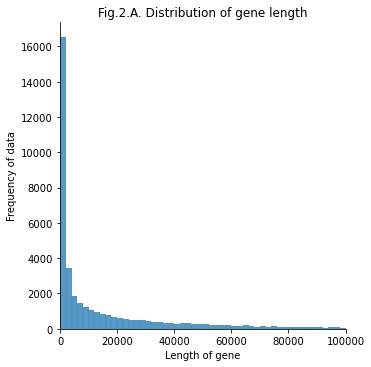

Fig.2.A. Displays the distriution of gene length in the dataset. Each bar represents a length of 2000.


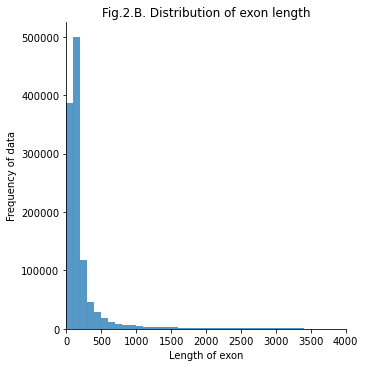

Fig.2.B. displays the distriution of exon length in the dataset. Each bar represents a length of 100.
129139131.0
5469773.0


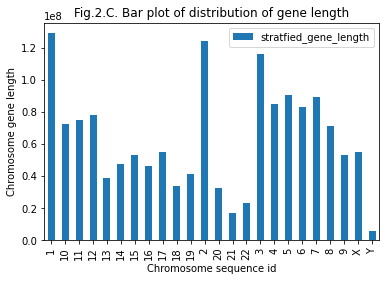

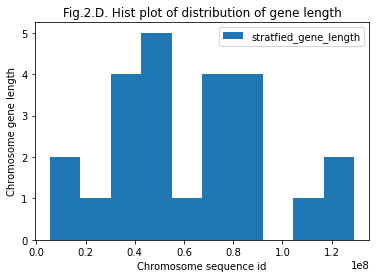

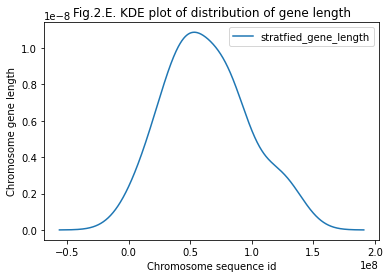

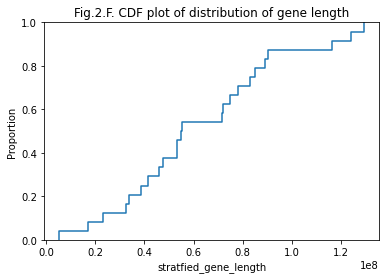

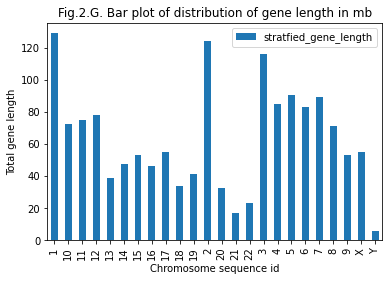

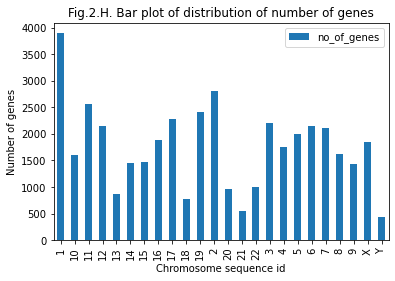

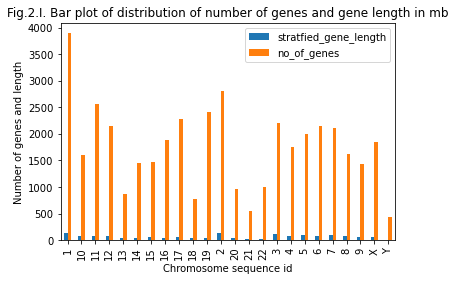

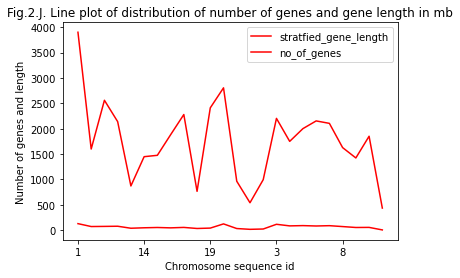

In [455]:
def main():
    df1 = import_gff3()
    df2 = genes_exon_number(df1)
    df3 = no_len_chromosome(df1)

if __name__ == "__main__":
    main()

# Part 2_Answers

In [ ]:
1.  Entries of gene = 42202
    Entries of exon = 1173026
    
2.  Median length of gene = 5104
    Median length od CDS = 115
    
    The median length of CDS is significantlly smaller than the median length of the gene.

3.  Fig.2.A. displays the distriution of gene length in the dataset. Each bar represents a length of 2000.
    Fig.2.B. displays the distriution of exon length in the dataset. Each bar represents a length of 100.
    
    From the plots we can conclude that the majority of gene and exon length fall under the same ratio (1:10) 
    group as the bar plots show similar pattern. Most gene fall on the gene length of range 2000 block while most 
    exon fall within length range of 200 block. The length frequency decreases as the length of exon or gene 
    increases in both plots.
    
4.  Fig.2.C. represents the plot of the distribution of gene length stratified by chromosome.
5.  Fig.2.D. represents the 'hist' plot of the distribution of gene length stratified by chromosome.
5.  Fig.2.E. represents the 'kde' plot of the distribution of gene length stratified by chromosome.
5.  Fig.2.F. represents the 'cdf' plot of the distribution of gene length stratified by chromosome.

6.  Fig.2.G. shows the plot of distribution of length genes of a chromosome.
    Fig.2.H. shows the plot of distribution of the number of genes on a chromosome.
    Fig.2.I. shows the bar plot of therelationship between the length of a chromosome and the number of genes on a chromosome.
    Fig.2.J. shows the line plot of the relationship between the length of a chromosome and the number of genes on a chromosome.


# Assignment1_Part3

/Users/nises/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (11,12,23) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


The average time between the study publication and its addition to the Catalog is: 6.979761983207719 months


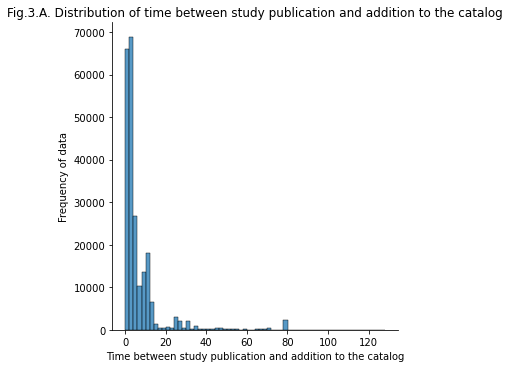

In [459]:
catalog_path = '/Users/nises/Desktop/Comp Biology/Assign1/data/gwas_catalog_v1.0.2-associations_e100_r2021-01-14.tsv'
catalog_data = pd.read_table(catalog_path)


for k in catalog_data.index:
    time_between = pd.Timedelta(to_datetime(catalog_data.at[k, 'DATE ADDED TO CATALOG']) - to_datetime(catalog_data.at[k, 'DATE']))
    catalog_data.at[k, 'TimeBetween'] = ((datetime.timedelta.total_seconds(time_between))/86400)/30
    
# print(catalog_data)
average_time = catalog_data['TimeBetween'].mean()

print('The average time between the study publication and its addition to the Catalog is: '+ str(average_time) + ' months')

# max_value = catalog_data["TimeBetween"].max()
# min_value = catalog_data["TimeBetween"].min()

sns.displot(catalog_data, x="TimeBetween", binwidth=2)
# plt.xlim(0, max_value)
plt.xlabel('Time between study publication and addition to the catalog')
plt.ylabel('Frequency of data')
plt.title('Fig.3.A. Distribution of time between study publication and addition to the catalog')
plt.show()


In [460]:
# Displaying the number of unique journals.
Journal_numbers = len(catalog_data.JOURNAL.unique())
jv = (catalog_data.JOURNAL.unique())
jv.sort()
print(Journal_numbers)

554


In [464]:
nature_prefixes = ['Nat Commun','Nat Genet','Nat Hum Behav','Nat Med','Nat Metab','Nat Microbiol','Nat Neurosci',
                   'Nature']
cell_prefixes = ['Cell','Cell Metab','Cell Mol Gastroenterol Hepatol','Cell Rep','Cell Syst','Cells']
    
plos_prefixes = ['PLoS Comput Biol','PLoS Genet','PLoS Med','PLoS One','PLoS Pathog']

jama_prefixes = ['JAMA','JAMA Cardiol','JAMA Dermatol','JAMA Netw Open','JAMA Neurol','JAMA Ophthalmol',
                 'JAMA Psychiatry']

      PUBMEDID   Group  count
0     27029810  Nature      2
1     27701424    PLoS      9
2     27244555  Nature      4
3     29875488  Nature   2784
4     27195777    PLoS      2
...        ...     ...    ...
1350  32986727    PLoS     32
1351  31978080    PLoS      1
1352  32915782    PLoS     12
1353  32989287  Nature     48
1354  30531825  Nature    309

[1355 rows x 3 columns]


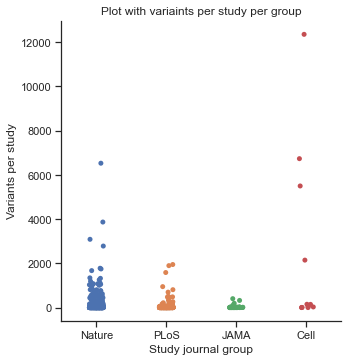

In [518]:
variants_data = catalog_data
variants_data = variants_data.loc[variants_data['JOURNAL'].str.startswith(('Nat', 'Cell', 'PLoS', 'JAMA'))]
li = (variants_data['JOURNAL'].unique())
li.sort()
variants_data = variants_data.reset_index(drop=True)
# print(variants_data)

variants_data['Group'] = 'nan'

for i in range(len(variants_data)):
    if(variants_data.loc[i]['JOURNAL'].startswith(('Nat'))):
        variants_data.at[i, 'Group'] = 'Nature'
    elif(variants_data.loc[i]['JOURNAL'].startswith(('Cell'))):
        variants_data.at[i, 'Group'] = 'Cell'
    elif(variants_data.loc[i]['JOURNAL'].startswith(('Science'))):
        variants_data.at[i, 'Group'] = 'Science'
    elif(variants_data.loc[i]['JOURNAL'].startswith(('PLoS'))):
        variants_data.at[i, 'Group'] = 'PLoS'
    elif(variants_data.loc[i]['JOURNAL'].startswith(('JAMA'))):
        variants_data.at[i, 'Group'] = 'JAMA'
# print(variants_data)
# variants_dat = variants_data.groupby(['Group','PUBMEDID']).count()
variants_data["count"] = variants_data.groupby(['Group','PUBMEDID'])['PUBMEDID'].transform('count')

v1 = variants_data.filter(['PUBMEDID', 'Group', 'count'])
v1 = v1.drop_duplicates().reset_index(drop='True')
print(v1)
# print(variants_data)

sns.set_theme(style="ticks")
g = sns.catplot(x="Group", y="count", data=v1)
plt.xlabel("Study journal group")
plt.ylabel("Variants per study")
plt.title("Plot with variaints per study per group")
plt.show()


In [381]:
foxp_data = catalog_data
foxp_data = foxp_data.loc[((foxp_data['REPORTED GENE(S)']) == 'FOXP2') | (foxp_data['MAPPED_GENE'] == 'FOXP2')]
print(foxp_data.shape)

# 3.1
li = (foxp_data['PUBMEDID'].unique())
li = li.tolist()
li.sort()
print('All reported variants= ' + str(len(li)))
print(li)

# 3.2
l1 = (foxp_data['DISEASE/TRAIT'].unique())
print('Unique DISEASE/TRAIT phenotypes: ' + str(len(l1)))
l1 = l1.tolist()
l2 = (foxp_data['MAPPED_TRAIT'].unique())
print('Unique MAPPED_TRAIT phenotypes: ' + str(len(l2)))
l2 = l2.tolist()
l1.extend(l2)

l3 = list(dict.fromkeys(l1))
l3.sort()
print('All unique associated phenotypes: ' + str(len(l3)))
print('\n')
print(l3)

(79, 39)
All reported variants= 42
[22936669, 23382691, 25189868, 25673413, 25811787, 26545240, 26926045, 27225129, 27412988, 27798627, 27992416, 28333195, 28468790, 28552196, 29255261, 29500382, 29844566, 30038396, 30181555, 30271922, 30289880, 30478444, 30595370, 30610198, 30643251, 30643258, 30696823, 30804565, 30804566, 30846698, 31194737, 31374203, 31511532, 31527586, 31844048, 31969693, 32066663, 32066696, 32246137, 32332799, 32606422, 32665545]
Unique DISEASE/TRAIT phenotypes: 51
Unique MAPPED_TRAIT phenotypes: 44
All unique associated phenotypes: 94


['Adventurousness', 'Age at first birth', 'Age of smoking initiation (MTAG)', 'Attention deficit hyperactivity disorder', 'Attention deficit hyperactivity disorder (MTAG)', 'Attention deficit hyperactivity disorder or cannabis use', 'Beard thickness', 'Blood pressure (smoking interaction)', 'Body mass index', 'Brain morphology (MOSTest)', 'Childhood maltreatment', 'Chronotype', 'Cognitive ability, years of educational attainment o

# Part 3 Answers

1.  The average time between the study publication and its addition to the Catalog is: 6.979761983207719 months.
    The Fig.3.A. is plotted with each bar set to 2 months. The plot shows that most of the study plublications are
    added to the catalog between 0 to 4 months. The website is slightly accurate as must publication are added
    within 1-2 months or 1-4 months.
    
2.  Study under cell and nature group have high variants count. If the cell and nature journal fall under high impact journals, then the hypothesis will be correct.
    
3.1. All of the variants with a reported or mapped association with FOXP2 are: 42
    [22936669, 23382691, 25189868, 25673413, 25811787, 26545240, 26926045, 27225129, 27412988, 27798627, 27992416, 28333195, 28468790, 28552196, 29255261, 29500382, 29844566, 30038396, 30181555, 30271922, 30289880, 30478444, 30595370, 30610198, 30643251, 30643258, 30696823, 30804565, 30804566, 30846698, 31194737, 31374203, 31511532, 31527586, 31844048, 31969693, 32066663, 32066696, 32246137, 32332799, 32606422, 32665545]
 
3.2. Unique DISEASE/TRAIT phenotypes: 51
     Unique MAPPED_TRAIT phenotypes: 44
     All unique associated phenotypes: 94
     
    ['Adventurousness', 'Age at first birth', 'Age of smoking initiation (MTAG)', 'Attention deficit hyperactivity disorder', 'Attention deficit hyperactivity disorder (MTAG)', 'Attention deficit hyperactivity disorder or cannabis use', 'Beard thickness', 'Blood pressure (smoking interaction)', 'Body mass index', 'Brain morphology (MOSTest)', 'Childhood maltreatment', 'Chronotype', 'Cognitive ability, years of educational attainment or schizophrenia (pleiotropy)', 'Congenital heart disease (maternal effect)', 'Conotruncal heart defects (maternal effects)', 'Conotruncal heart malformations', "Crohn's disease", 'Deep ovarian and/or rectovaginal disease with dense adhesions', 'Educational attainment (MTAG)', 'Educational attainment (years of education)', 'Feeling tense', 'Fish- and plant-related diet', 'Gastroesophageal reflux disease', 'General cognitive ability', 'General risk tolerance (MTAG)', 'Height', 'Highest math class taken (MTAG)', 'Household income (MTAG)', 'IgG glycosylation', 'Insomnia', 'Insomnia symptoms (never/rarely vs. sometimes/usually)', 'Insomnia symptoms (never/rarely vs. usually)', 'Irritable mood', 'Morning person', 'Morningness', 'Multisite chronic pain', 'Neck pain or shoulder pain', 'Neuroticism', 'Number of sexual partners', 'Pelvic organ prolapse (moderate/severe)', 'Reaction time', 'Self-reported risk-taking behaviour', 'Serum sulfate level', 'Shoulder pain, Neck pain', 'Sleep duration', 'Sleep duration (short sleep)', 'Smoking initiation (ever regular vs never regular) (MTAG)', 'Social science traits (pleiotropy) (HIPO component 1)', 'Subcortical volume (MOSTest)', 'Trauma exposure', 'Urate levels in obese individuals', 'Urinary albumin-to-creatinine ratio in diabetes', 'Weight', 'age at first birth measurement', 'attention deficit hyperactivity disorder', 'attention deficit hyperactivity disorder, Cannabis use', 'body height', 'body mass index', 'body weight', 'brain measurement, neuroimaging measurement', 'childhood trauma measurement', 'chronotype measurement', 'congenital heart disease', 'diabetes mellitus, urinary albumin to creatinine ratio', 'diet measurement', 'endometriosis', 'facial hair thickness measurement', 'feeling tense measurement', 'gastroesophageal reflux disease', 'household income', 'insomnia', 'insomnia measurement', 'intelligence', 'irritability measurement', 'mathematical ability', 'multisite chronic pain', 'neuroimaging measurement, brain volume measurement', 'neuroticism measurement', 'neuroticism measurement, wellbeing measurement, depressive symptom measurement', 'obese body mass index status, urate measurement', 'pack-years measurement, systolic blood pressure', 'pelvic organ prolapse', 'reaction time measurement', 'risk-taking behaviour', 'risky sexual behaviour measurement', 'schizophrenia, intelligence, self reported educational attainment', 'self reported educational attainment', 'serum IgG glycosylation measurement', 'sleep duration', 'smoking initiation', 'smoking status measurement', 'sulfate measurement', 'systolic blood pressure, cigarettes per day measurement', 'trauma exposure measurement']